# Deep Learning Medical Image Analysis for Multiclass Classification
A simple convolutional neural network model trained using a Dermatoscope(DermaMNIST) image dataset.

#### Dataset Description
The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task.

We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.

#### Dataset Labels:
'0': 'actinic keratoses and intraepithelial carcinoma',
'1': 'basal cell carcinoma',
'2': 'benign keratosis-like lesions',
'3': 'dermatofibroma',
'4': 'melanoma',
'5': 'melanocytic nevi',
'6': 'vascular lesions'

## Python Imports
This section will load the necessary python packages to the instance.

In [1]:
# Built-in Imports
import random

In [2]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [30]:
# Keras Imports
from tensorflow.keras import layers,utils,preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Downloader
This section will download the selected [MedMNIST](https://medmnist.github.io/) dataset as a NumPy array object to your Google Colab instance. 

To change the dataset that will download just change the variable DATA_NAME to desired dataset name.

In [4]:
DATA_NAME = "DermaMNIST"

In [5]:
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2022-04-08 20:41:39--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22843 (22K) [text/plain]
Saving to: ‘info.py’

info.py             100%[===================>]  22.31K  --.-KB/s    in 0s      

2022-04-08 20:41:39 (65.0 MB/s) - ‘info.py’ saved [22843/22843]



In [6]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz", 
                     origin=data["url"], 
                     md5_hash=data["MD5"])

19734528/19725078 [==============================] - 1s 0us/step


In [7]:
# Data Information
data

{'MD5': '0744692d530f8e62ec473284d019b0c7',
 'description': 'The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.',
 'label': {'0': 'actinic keratoses and intraepithelial carcinoma',
  '1': 'basal cell carcinoma',
  '2': 'benign keratosis-like lesions',
  '3': 'dermatofibroma',
  '4': 'melanoma',
  '5': 'melanocytic nevi',
  '6': 'vascular lesions'},
 'license': 'CC BY-NC 4.0',
 'n_channels': 3,
 'n_samples': {'test': 2005, 'train': 7007, 'val': 1003},
 'python_class': 'DermaMNIST',
 'task': 'multi-class',
 'url': 'https://zenodo.org/record/5208230/files/dermamnist.npz?download=1'}

In [8]:
# Loads the downloaded NumPy object.
dataset = np.load(file_path)

# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
train_y = dataset["train_labels"]

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
val_y = dataset["val_labels"]

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
test_y = dataset["test_labels"]

In [8]:
train_x.shape,train_y.shape,val_x.shape,test_x.shape

((7007, 28, 28, 3), (7007, 1), (1003, 28, 28, 3), (2005, 28, 28, 3))

['actinic keratoses and intraepithelial carcinoma',
 'basal cell carcinoma',
 'benign keratosis-like lesions',
 'dermatofibroma',
 'melanoma',
 'melanocytic nevi',
 'vascular lesions',
 'total']

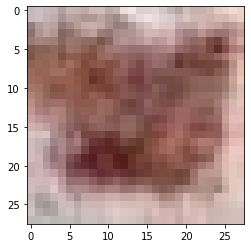

In [9]:
plt.imshow(train_x[100])
list(data["label"].values()) + ["total"]

## Data Exploration
In this section we have a look at our data, their distributions to see if it is ready to be used within our machine learning algorithm.

In [10]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]

# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset.
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]), 
                            np.append(val_counts, [sum(val_counts)]), 
                            np.append(test_counts, [sum(test_counts)]))), 
                   index=labels, columns=["Train", "Val", "Test"]))

                                                 Train   Val  Test
actinic keratoses and intraepithelial carcinoma    228    33    66
basal cell carcinoma                               359    52   103
benign keratosis-like lesions                      769   110   220
dermatofibroma                                      80    12    23
melanoma                                           779   111   223
melanocytic nevi                                  4693   671  1341
vascular lesions                                    99    14    29
total                                             7007  1003  2005


3614: basal cell carcinoma


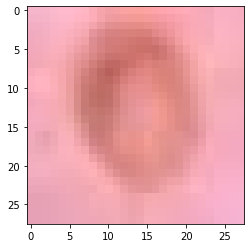

In [11]:
# Displays a random image from training dataset.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[random.randint(0, len(train_x))])

## Data Processing
In this section we will create a data loader for algorithm that will dynamiclly load and augment the data when needed.

In [12]:
# Defines the data generator that will be used to augment the images as they are loaded.
data_generator = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True, 
                                    vertical_flip=True)

In [13]:
# Fit the Data on Data Generator
data_generator.fit(np.append(train_x, val_x, 0))

## Model Definition Assn Q1

#### Below is Neural Network Architecture for Assn Q1

A convnet with the same architecture and training regime as in the example Colab notebook
provided above. (You should alter the last layer and the loss function as appropriate, depending on
the number of classes).

In [14]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Defines the first convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(input)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

# Defines the second convolutional layer with max pooling.
conv_2 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)

# Flattens the outputs of the convolutoonal layers into a one dimensional array.
flatten = layers.Flatten()(pool_2)

# Defines the output layer of the model a number of output nodes equal to the number of classes.
output = layers.Dense(units=len(np.unique(train_y)), activation="softmax")(flatten)

# Initilises the defined model and prints summary of the model.
model = Model(inputs=input, outputs=output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0     

## Model Training Assn Q1
This is where we define the training options and then train the model.


In [15]:
# Defines the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [16]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
# We use the data generator to pass the training and validation data to the model to train it.
history = model.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE), 
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/10
109/109 [==============================] - 8s 69ms/step - loss: 1.3660 - accuracy: 0.5940 - val_loss: 1.1397 - val_accuracy: 0.6690
Epoch 2/10
109/109 [==============================] - 6s 52ms/step - loss: 1.0999 - accuracy: 0.6686 - val_loss: 1.0494 - val_accuracy: 0.6690
Epoch 3/10
109/109 [==============================] - 6s 55ms/step - loss: 1.0273 - accuracy: 0.6680 - val_loss: 0.9990 - val_accuracy: 0.6700
Epoch 4/10
109/109 [==============================] - 6s 57ms/step - loss: 0.9895 - accuracy: 0.6669 - val_loss: 0.9724 - val_accuracy: 0.6740
Epoch 5/10
109/109 [==============================] - 6s 56ms/step - loss: 0.9674 - accuracy: 0.6672 - val_loss: 0.9548 - val_accuracy: 0.6680
Epoch 6/10
109/109 [==============================] - 6s 55ms/step - loss: 0.9548 - accuracy: 0.6709 - val_loss: 0.9377 - val_accuracy: 0.6770
Epoch 7/10
109/109 [==============================] - 6s 54ms/step - loss: 0.9474 - accuracy: 0.6713 - val_loss: 0.9292 - val_accuracy: 0.6740

In [19]:
test_x.shape,test_y.shape,train_x.shape,train_y.shape

((2005, 28, 28, 3), (2005, 1), (7007, 28, 28, 3), (7007, 1))

In [18]:
# Evaluating model on test data
test_y = utils.to_categorical(test_y)

In [19]:
model.evaluate(test_x, test_y)

63/63 [==============================] - 1s 10ms/step - loss: 60.9650 - accuracy: 0.6688


[60.9649658203125, 0.6688279509544373]

## Plot Learning Curves Assn Q1
This is where we visualise the training of the model.

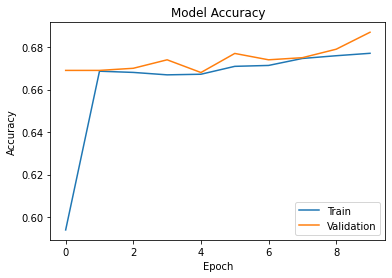

In [20]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

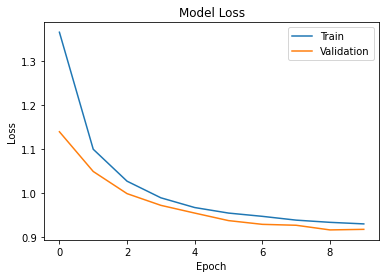

In [21]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Model Definition Assn Q2
In this section we will define the neural network arcitecture.

#### Below is Neural Network Architecture for Assn Q2

A network with dense layers but no convolutional layers, designed to have a total number of
parameters comparable to the convnet in 1.

In [22]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Dense Layers
flatten = layers.Flatten()(input)
dense1 = layers.Dense(8, activation='relu')(flatten)
dense2 = layers.Dense(8, activation='relu')(dense1)
# dense3 = layers.Dense(64, activation='relu')(dense2)

# Defines the output layer of the model a number of output nodes equal to the number of classes.
output = layers.Dense(units=len(np.unique(train_y)), activation="softmax")(dense2)

# Initilises the defined model and prints summary of the model.
modelDense = Model(inputs=input, outputs=output, name="Model")
modelDense.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 2352)              0         
                                                                 
 dense_1 (Dense)             (None, 8)                 18824     
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 7)                 63        
                                                                 
Total params: 18,959
Trainable params: 18,959
Non-trainable params: 0
_________________________________________________________________


## Model Training Assn Q2
This is where we define the training options and then train the model.


In [23]:
# Defines the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [24]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
modelDense.compile(optimizer=optimiser, loss="categorical_crossentropy", metrics=["accuracy"])

In [25]:
# We use the data generator to pass the training and validation data to the model to train it.
history = modelDense.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE), 
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/10
109/109 [==============================] - 1s 10ms/step - loss: 1.8346 - accuracy: 0.2674 - val_loss: 1.5695 - val_accuracy: 0.5693
Epoch 2/10
109/109 [==============================] - 1s 8ms/step - loss: 1.4170 - accuracy: 0.6145 - val_loss: 1.2931 - val_accuracy: 0.6421
Epoch 3/10
109/109 [==============================] - 1s 9ms/step - loss: 1.2423 - accuracy: 0.6496 - val_loss: 1.1832 - val_accuracy: 0.6491
Epoch 4/10
109/109 [==============================] - 1s 9ms/step - loss: 1.1634 - accuracy: 0.6561 - val_loss: 1.1360 - val_accuracy: 0.6520
Epoch 5/10
109/109 [==============================] - 1s 9ms/step - loss: 1.1197 - accuracy: 0.6638 - val_loss: 1.0988 - val_accuracy: 0.6580
Epoch 6/10
109/109 [==============================] - 1s 9ms/step - loss: 1.0925 - accuracy: 0.6649 - val_loss: 1.0635 - val_accuracy: 0.6630
Epoch 7/10
109/109 [==============================] - 1s 9ms/step - loss: 1.0686 - accuracy: 0.6665 - val_loss: 1.0585 - val_accuracy: 0.6660
Epoch

In [37]:
test_x.shape,test_y.shape,train_x.shape,train_y.shape

((2005, 28, 28, 3), (2005, 1), (7007, 28, 28, 3), (7007, 1))

In [47]:
test_x.shape,test_y.shape

((2005, 28, 28, 3), (2005, 7))

In [46]:
# Evaluating model on test data
test_y = utils.to_categorical(test_y)

In [26]:
# Test Loss and Test Accuracy
modelDense.evaluate(test_x, test_y)

63/63 [==============================] - 0s 2ms/step - loss: 43.5444 - accuracy: 0.6030


[43.54444885253906, 0.6029925346374512]

## Plot Learning Curves Assn Q2
This is where we visualise the training of the model.

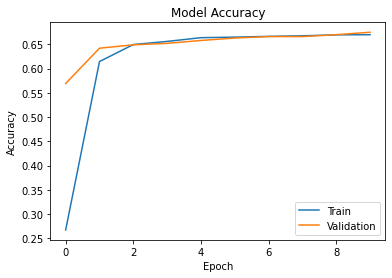

In [27]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

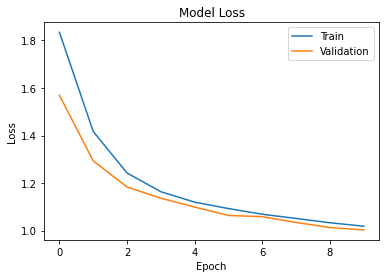

In [28]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Data Processing Q3
In this section we will create a data loader for algorithm that will dynamiclly load and augment the data when needed.

In [43]:
# Defines the data generator that will be used to augment the images as they are loaded.
data_generator = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True, 
                                    vertical_flip=True,
                                    rotation_range=90,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.1,
                                    fill_mode='nearest',
                                    )


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


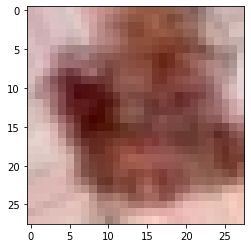

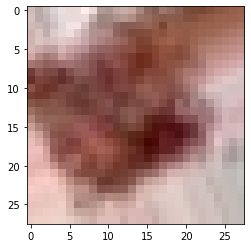

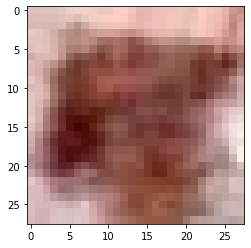

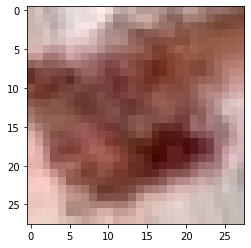

In [45]:
# We pick one image to "augment"
x = preprocessing.image.img_to_array(train_x[100])

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in data_generator.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(preprocessing.image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [32]:
data_generator.fit(np.append(train_x, val_x, 0))

## Model Definition Assn Q3
A deep network of your own design, incorporating design techniques and regularisation methods
you have learned about. You should use data augmentation. Try to achieve a good performance on
the test data


#### Below is Neural Network Architecture for Assn Q3

A network with dense layers but no convolutional layers, designed to have a total number of
parameters comparable to the convnet in 1.

In [157]:
# Defines the first convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(input)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

# Defines the second convolutional layer with max pooling.
conv_2 = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)

# Defines the second convolutional layer with max pooling.
conv_3 = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(pool_2)
pool_3 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)
flatten = layers.Flatten()(pool_3)

# Defines the output layer of the model a number of output nodes equal to the number of classes.
dense1 = layers.Dense(128, activation='relu')(flatten)
dropout1 = layers.Dropout(0.2)(dense1)
dense2 = layers.Dense(64, activation='relu')(dropout1)
output = layers.Dense(units=len(np.unique(train_y)), activation="softmax")(dense2)

# Initilises the defined model and prints summary of the model.
modelCustom = Model(inputs=input, outputs=output, name="Model")
modelCustom.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_129 (Conv2D)         (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d_126 (MaxPooli  (None, 13, 13, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_130 (Conv2D)         (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_128 (MaxPooli  (None, 5, 5, 128)        0         
 ng2D)                                                           
                                                                 
 flatten_40 (Flatten)        (None, 3200)              0     

## Model Training Assn Q3
This is where we define the training options and then train the model.


In [162]:
# Defines the parameters used during training.
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 0.001

In [163]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
modelCustom.compile(optimizer=optimiser, loss="categorical_crossentropy", metrics=["accuracy"])

In [164]:
# We use the data generator to pass the training and validation data to the model to train it.
history = modelCustom.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE), 
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


218/218 [==============================] - 18s 82ms/step - loss: 0.8965 - accuracy: 0.6780 - val_loss: 0.8787 - val_accuracy: 0.6600
Epoch 2/15
218/218 [==============================] - 18s 81ms/step - loss: 0.8934 - accuracy: 0.6815 - val_loss: 0.8657 - val_accuracy: 0.6810
Epoch 3/15
218/218 [==============================] - 18s 81ms/step - loss: 0.8851 - accuracy: 0.6809 - val_loss: 0.8642 - val_accuracy: 0.6889
Epoch 4/15
218/218 [==============================] - 18s 81ms/step - loss: 0.8854 - accuracy: 0.6835 - val_loss: 0.8598 - val_accuracy: 0.6780
Epoch 5/15
218/218 [==============================] - 18s 82ms/step - loss: 0.8839 - accuracy: 0.6833 - val_loss: 0.8428 - val_accuracy: 0.7019
Epoch 6/15
218/218 [==============================] - 18s 81ms/step - loss: 0.8740 - accuracy: 0.6833 - val_loss: 0.8792 - val_accuracy: 0.6780
Epoch 7/15
218/218 [==============================] - 18s 81ms/step - loss: 0.8778 - accuracy: 0.6809 - val_loss: 0.8627 - val_accuracy: 0.6849
Epo

In [ ]:
test_x.shape,test_y.shape,train_x.shape,train_y.shape

((2005, 28, 28, 3), (2005, 1), (7007, 28, 28, 3), (7007, 1))

In [ ]:
test_x.shape,test_y.shape

((2005, 28, 28, 3), (2005, 7))

In [ ]:
# Evaluating model on test data
test_y = utils.to_categorical(test_y)

In [161]:
# Test Loss and Test Accuracy
modelCustom.evaluate(test_x, test_y)

63/63 [==============================] - 1s 20ms/step - loss: 0.8527 - accuracy: 0.6853


[0.8527277112007141, 0.6852867603302002]

In [165]:
modelCustom.evaluate(test_x, test_y)

63/63 [==============================] - 1s 19ms/step - loss: 0.8022 - accuracy: 0.6913


[0.8022259473800659, 0.6912718415260315]

## Plot Learning Curves Assn Q3
This is where we visualise the training of the model.

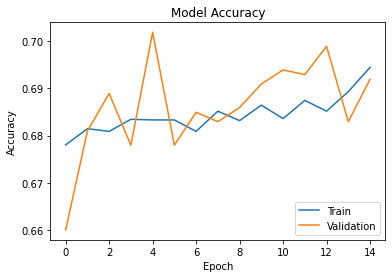

In [166]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

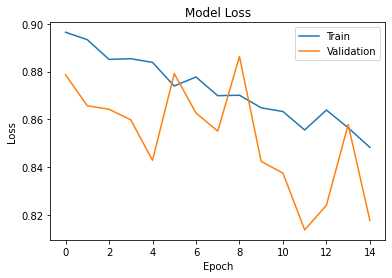

In [167]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

###The Conclusion, Graph and data comparison is in attached word file. 

